# Workspace to dvelope r.basin route

In [102]:
# Import Python standard library and IPython packages we need.
import os
import subprocess
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pprint import pprint
import json
import time
import requests
from requests.auth import HTTPBasicAuth

# Ask GRASS GIS where its Python packages are.
gisbase = subprocess.check_output(["grass", "--config", "path"], text=True).strip()
os.environ["GISBASE"] = gisbase
os.environ["ACTINIA_USER"] = 'actinia-gdi'
os.environ["ACTINIA_PASSWORD"] = 'actinia-gdi'
os.environ["AUTH"] = 'actinia-gdi:actinia-gdi'
os.environ["ACTINIA_URL"] = 'http://localhost:8088'

ACTINIA_VERSION = 'v3'
ACTINIA_BASEURL = 'http://localhost:8088'
ACTINIA_URL = ACTINIA_BASEURL + "/api/" + ACTINIA_VERSION
ACTINIA_AUTH = HTTPBasicAuth("actinia-gdi", "actinia-gdi")
sys.path.append(os.path.join(gisbase, "etc", "python"))

# Import the GRASS GIS packages we need.
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
## Set your grass data location
gj.init("../actinia-core-data/grassdb", "nc_spm_08", "PERMANENT")

In [66]:
def print_as_json(data):
    print(json.dumps(data, indent=2))

In [103]:
location = "nc_spm_08"
mapset = "basin_test"

## Import DEM from Google Cloud Storage

In [111]:
!importer raster="dem_10m_mosaic@https://storage.googleapis.com/tomorrownow-actinia-dev/dem_10m_mosaic_cog.tif"

In [119]:
!importer raster="direction_3k@https://storage.googleapis.com/tomorrownow-actinia-dev/direction_3k_cog.tif"

In [123]:
!ace location="nc_spm_08" mapset="basin_test" -r

['dem_10m_mosaic', 'dem_10m_slope', 'direction_3k', 'point_basin']


In [18]:
!ace --help

Allows the execution of single GRASS GIS command or a list of GRASS GIS commands on an actinia REST service.

Usage:
 ace [-adlmrvs] [grass_command=string] [script=string] [location=value]
   [mapset=value] [list_jobs=value] [info_job=value] [kill_job=value]
   [create_location=value] [delete_location=value] [create_mapset=value]
   [delete_mapset=value] [render_raster=value] [render_vector=value]
   [render_strds=value] [--help] [--verbose] [--quiet] [--ui]

Flags:
  -a   Request the version of the actinia server
  -d   Dry run: just print the JSON request and do not send the generated request to the server
  -l   List locations the user has access to
  -m   List mapsets within specified location
  -r   List raster maps of mapsets of specified location
  -v   List vector maps of mapsets of specified location
  -s   List STRDS of mapsets of specified location

Parameters:
    grass_command   GRASS GIS command to be executed
           script   Script file from which all all commands wi

In [109]:
!ace location="nc_spm_08" create_mapset="basin_test"

Trying to create mapset basin_test
{'accept_datetime': '2022-04-19 15:01:35.061490',
 'accept_timestamp': 1650380495.0614896,
 'api_info': {'endpoint': 'mapsetmanagementresourceadmin',
              'method': 'POST',
              'path': '/api/v3/locations/nc_spm_08/mapsets/basin_test',
              'request_url': 'http://localhost:8088/api/v3/locations/nc_spm_08/mapsets/basin_test'},
 'datetime': '2022-04-19 15:01:35.231492',
 'exception': {'message': 'AsyncProcessError:  Mapset <basin_test> exists.',
               'traceback': ['  File '
                             '"/usr/lib/python3.8/site-packages/actinia_core/processing/actinia_processing/ephemeral_processing.py", '
                             'line 1641, in run\n'
                             '    self._execute()\n',
                             '  File '
                             '"/usr/lib/python3.8/site-packages/actinia_core/processing/actinia_processing/persistent/mapset_management.py", '
                             

In [110]:
!ace location="nc_spm_08"  -m

['PERMANENT', 'basin_test', 'landsat', 'test', 'test_ms', 'user1']


In [51]:
cloud_dem = "dem_10m_mosaic@https://storage.googleapis.com/tomorrownow-actinia-dev/dem_10m_mosaic_cog.tif"
slope = "dem_10m_slope"
r_slope_command = f"r.slope.aspect elevation=${cloud_dem} slope=${slope}"
print(r_slope_command)

r.slope.aspect elevation=$dem_10m_mosaic@https://storage.googleapis.com/tomorrownow-actinia-dev/dem_10m_mosaic_cog.tif slope=$dem_10m_slope


In [120]:
# r_slope_body = !ace location="nc_spm_08" mapset="basin_test" grass_command="r.slope.aspect elevation=dem_10m_mosaic@https://storage.googleapis.com/tomorrownow-actinia-dev/dem_10m_mosaic_cog.tif slope=dem_10m_slope" -d

!ace location="nc_spm_08" mapset="basin_test" script="./scripts/basin.sh" -d

{
  "version": "1",
  "list": [
    {
      "module": "g.region",
      "id": "g.region_1804289383",
      "inputs": [
        {
          "import_descr": {
            "source": "https://storage.googleapis.com/tomorrownow-actinia-dev/dem_10m_mosaic_cog.tif",
            "type": "raster"
          },
          "param": "raster",
          "value": "dem_10m_mosaic"
        },
        {
          "param": "res",
          "value": "10"
        }
      ]
    },
    {
      "module": "r.circle",
      "id": "r.circle_1804289383",
      "flags": "b",
      "inputs": [
        {
          "param": "coordinates",
          "value": "0,0"
        },
        {
          "param": "max",
          "value": "200"
        }
      ],
      "outputs": [
        {
          "param": "output",
          "value": "circle"
        }
      ]
    },
    {
      "module": "r.stream.basins",
      "id": "r.stream.basins_1804289383",
      "flags": "c",
      "inputs": [
        {
          "param": "directio

In [97]:
r_slope_body

['{',
 '  "version": "1",',
 '  "list": [',
 '    {',
 '      "module": "g.region",',
 '      "id": "g.region_1804289383",',
 '      "inputs": [',
 '        {',
 '          "import_descr": {',
 '            "source": "https://storage.googleapis.com/tomorrownow-actinia-dev/dem_10m_mosaic_cog.tif",',
 '            "type": "raster"',
 '          },',
 '          "param": "raster",',
 '          "value": "dem_10m_mosaic"',
 '        },',
 '        {',
 '          "param": "res",',
 '          "value": "10"',
 '        }',
 '      ]',
 '    },',
 '    {',
 '      "module": "r.slope.aspect",',
 '      "id": "r.slope.aspect_1804289383",',
 '      "inputs": [',
 '        {',
 '          "import_descr": {',
 '            "source": "https://storage.googleapis.com/tomorrownow-actinia-dev/dem_10m_mosaic_cog.tif",',
 '            "type": "raster"',
 '          },',
 '          "param": "elevation",',
 '          "value": "dem_10m_mosaic"',
 '        },',
 '        {',
 '          "param": "format",

In [94]:
# make a POST request to the Actinia Data API
# request_url = actinia_url + "# make a POST request to the Actinia Data API
request_url = ACTINIA_URL + f"/locations/{location}/mapsets/{mapset}/processing_async"
print("actinia POST request:")
print(request_url)
request_body = json.loads("".join(r_slope_body))
print(request_body)
print("---")
request = requests.post(
    url=request_url, 
    auth=ACTINIA_AUTH,
    json=request_body
)

# get a json-encoded content of the response
jsonResponse = request.json()

print("Waiting for the process to finish...\n")
print(jsonResponse)
if jsonResponse["status"] in ("accepted", "running"):
    # poll the resource until status has changed
    request_url = jsonResponse["urls"]["status"]
    request = requests.get(url=request_url, auth=ACTINIA_AUTH)
    jsonResponse = request.json()
    
    if jsonResponse["status"] not in ("error"):
    

        while jsonResponse["status"] in ("accepted", "running"):
            time.sleep(1)
            jsonResponse = request.json()

        print("Slope computation of dem_10m_mosaic stored on google cloud:")
    else:
        print("Error Occured...")
        # print formatted JSON
    print_as_json(jsonResponse)

    


actinia POST request:
http://localhost:8088/api/v3/locations/nc_spm_08/mapsets/basin_test/processing_async
{'version': '1', 'list': [{'module': 'g.region', 'id': 'g.region_1804289383', 'inputs': [{'import_descr': {'source': 'https://storage.googleapis.com/tomorrownow-actinia-dev/dem_10m_mosaic_cog.tif', 'type': 'raster'}, 'param': 'raster', 'value': 'dem_10m_mosaic'}, {'param': 'res', 'value': '10'}]}, {'module': 'r.slope.aspect', 'id': 'r.slope.aspect_1804289383', 'inputs': [{'import_descr': {'source': 'https://storage.googleapis.com/tomorrownow-actinia-dev/dem_10m_mosaic_cog.tif', 'type': 'raster'}, 'param': 'elevation', 'value': 'dem_10m_mosaic'}, {'param': 'format', 'value': 'degrees'}, {'param': 'precision', 'value': 'FCELL'}, {'param': 'zscale', 'value': '1.0'}, {'param': 'min_slope', 'value': '0.0'}], 'outputs': [{'param': 'slope', 'value': 'dem_10m_slope'}]}]}
---


KeyboardInterrupt: 

In [ ]:
!ace list_jobs='all' | grep '2022-04-12' | cut -f 2 -d " " | sort

In [72]:
!ace location="nc_spm_08" mapset="basin_test" -r

['dem_10m_mosaic', 'dem_10m_slope']


In [74]:
def show_rendered_map(map_name, map_type, LOCATION, mapset="PERMANENT"):
    
    import requests
    from pprint import pprint
    
    """Show a rendered map with the size of 800x600 pixel
    Args:
        map_name: The name of the raster map with optional mapset (name@mapset)
    """

    fig, ax = plt.subplots(figsize=(20, 18))
    
    if "@" in map_name:
        map_name, mapset = map_name.split("@")
    else:
        mapset = mapset

    print(f"Trying to render {map_type} map {map_name} of mapset {mapset}")
    url = f"{ACTINIA_URL}/locations/{LOCATION}/mapsets" \
        f"/{mapset}/{map_type}/{map_name}/render?width=800&height=600"
    print(url)
    r = requests.get(url, auth=ACTINIA_AUTH)
    if r.status_code != 200:
        pprint(r.text)
    else:
        from PIL import Image
        import io

        fp = io.BytesIO(r.content)
        image = Image.open(fp)
        imgplot = plt.imshow(image)
        ax.set_title(map_name)
        ax.set_axis_off()
        plt.tight_layout() 



In [ ]:
show_rendered_map("dem_10m_mosaic@basin_test","raster_layers", LOCATION='nc_spm_08')


Trying to render raster_layers map point_basin of mapset basin_test
http://localhost:8088/api/v3/locations/nc_spm_08/mapsets/basin_test/raster_layers/point_basin/render?width=800&height=600


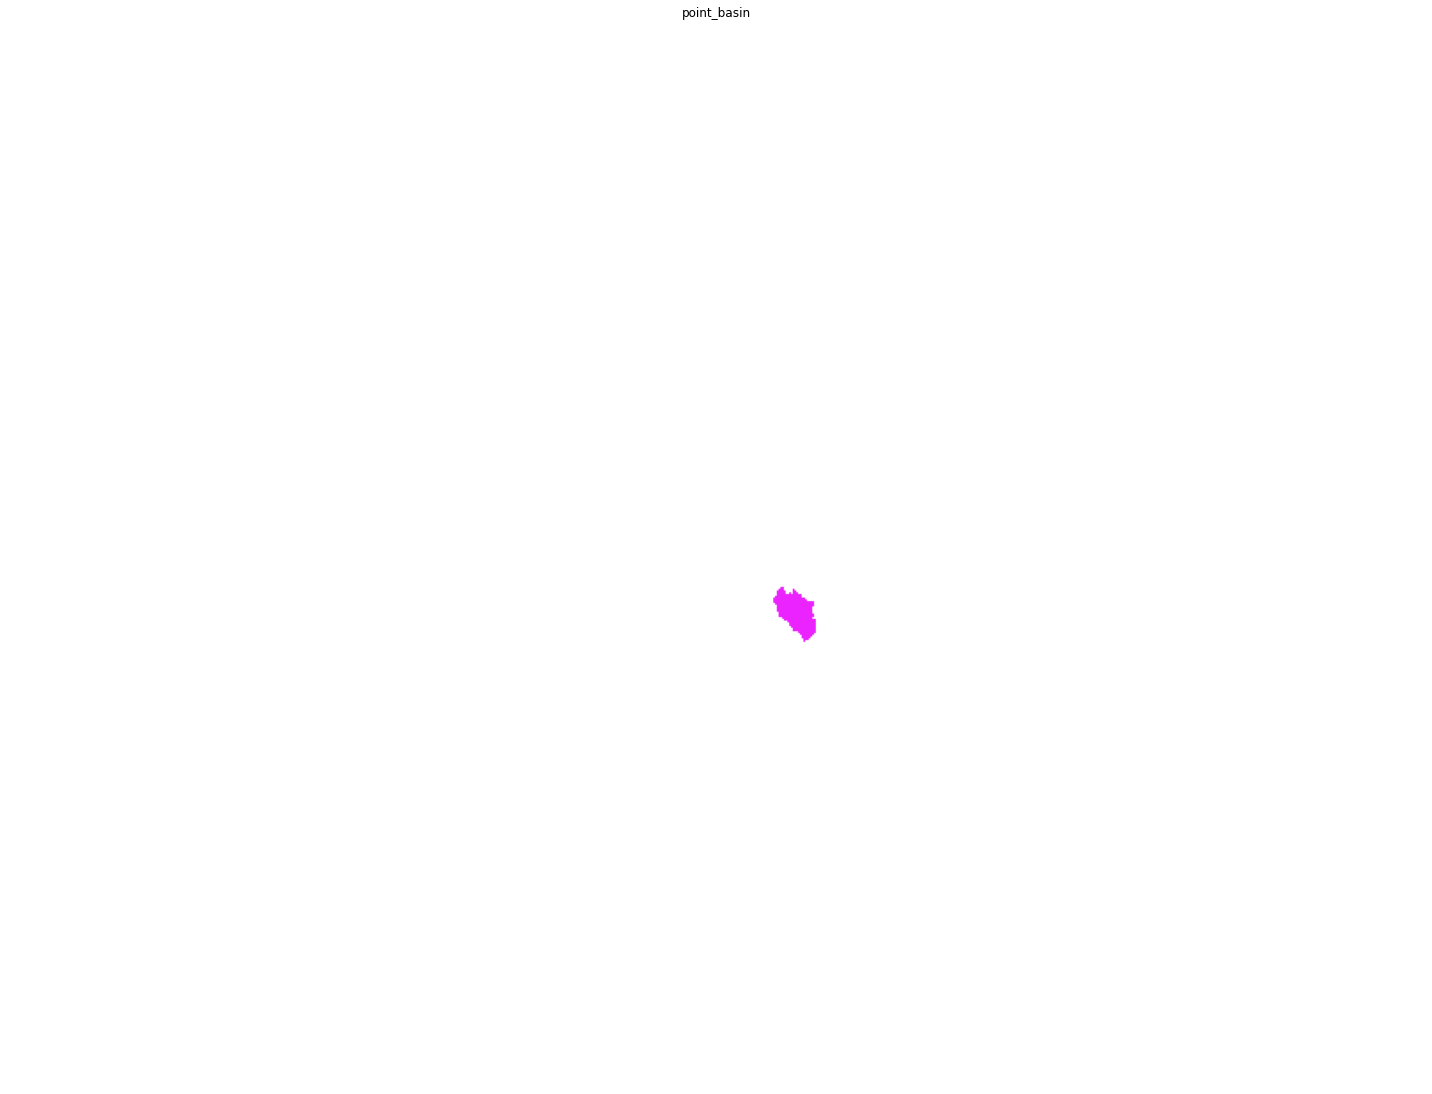

In [136]:
show_rendered_map("point_basin@basin_test","raster_layers", LOCATION='nc_spm_08')
# ['dem_10m_mosaic', 'dem_10m_slope', 'direction_3k', 'point_basin']

In [106]:
!ace location="nc_spm_08" mapset="basin_test" script="./scripts/install_grass_plugins.sh"

http://localhost:8088/api/v3/locations/nc_spm_08/mapsets/basin_test/processing_async
{'version': '1', 'list': [{'module': 'g.extension', 'id': 'g.extension_1804289383', 'inputs': [{'param': 'extension', 'value': 'r.stream.basins'}, {'param': 'operation', 'value': 'add'}, {'param': 'prefix', 'value': '$GRASS_ADDON_BASE'}]}, {'module': 'g.extension', 'id': 'g.extension_1804289383', 'inputs': [{'param': 'extension', 'value': 'r.stream.order'}, {'param': 'operation', 'value': 'add'}, {'param': 'prefix', 'value': '$GRASS_ADDON_BASE'}]}, {'module': 'g.extension', 'id': 'g.extension_1804289383', 'inputs': [{'param': 'extension', 'value': 'r.stream.stats'}, {'param': 'operation', 'value': 'add'}, {'param': 'prefix', 'value': '$GRASS_ADDON_BASE'}]}, {'module': 'g.extension', 'id': 'g.extension_1804289383', 'inputs': [{'param': 'extension', 'value': 'r.stream.distance'}, {'param': 'operation', 'value': 'add'}, {'param': 'prefix', 'value': '$GRASS_ADDON_BASE'}]}, {'module': 'g.extension', 'id': '

In [107]:
!ace info_job=resource_id-befd3319-b8a3-4026-9aaa-54a35105fa65

{'accept_datetime': '2022-04-18 19:38:36.917561',
 'accept_timestamp': 1650310716.9175608,
 'api_info': {'endpoint': 'asyncpersistentresource',
              'method': 'POST',
              'path': '/api/v3/locations/nc_spm_08/mapsets/basin_test/processing_async',
              'request_url': 'http://localhost:8088/api/v3/locations/nc_spm_08/mapsets/basin_test/processing_async'},
 'datetime': '2022-04-18 19:38:49.026388',
 'http_code': 200,
 'message': 'Processing successfully finished',
 'process_chain_list': [{'list': [{'id': 'g.extension_1804289383',
                                   'inputs': [{'param': 'extension',
                                               'value': 'r.stream.basins'},
                                              {'param': 'operation',
                                               'value': 'add'},
                                              {'param': 'prefix',
                                               'value': '$GRASS_ADDON_BASE'}],
                 

In [100]:
!ace location="nc_spm_08" mapset="basin_test" script="./scripts/install_grass_plugins.sh"

http://localhost:8088/api/v3/locations/nc_spm_08/mapsets/basin_test/processing_async
{'version': '1', 'list': [{'module': 'g.extension', 'id': 'g.extension_1804289383', 'inputs': [{'param': 'extension', 'value': 'r.futures.pga'}, {'param': 'operation', 'value': 'add'}, {'param': 'prefix', 'value': '$GRASS_ADDON_BASE'}]}, {'module': 'g.extension', 'id': 'g.extension_1804289383', 'inputs': [{'param': 'extension', 'value': 'r.futures.potential'}, {'param': 'operation', 'value': 'add'}, {'param': 'prefix', 'value': '$GRASS_ADDON_BASE'}]}, {'module': 'g.extension', 'id': 'g.extension_1804289383', 'inputs': [{'param': 'extension', 'value': 'r.futures.potsurface'}, {'param': 'operation', 'value': 'add'}, {'param': 'prefix', 'value': '$GRASS_ADDON_BASE'}]}, {'module': 'g.extension', 'id': 'g.extension_1804289383', 'inputs': [{'param': 'extension', 'value': 'r.futures.demand'}, {'param': 'operation', 'value': 'add'}, {'param': 'prefix', 'value': '$GRASS_ADDON_BASE'}]}, {'module': 'g.extension',

In [101]:
r_slope_body = !ace location="nc_spm_08" script="./scripts/install_grass_plugins.sh" -d

In [129]:
!ace info_job=resource_id-13e68800-1efb-4842-afd3-110eda06f8b1

{'accept_datetime': '2022-04-20 01:12:27.612952',
 'accept_timestamp': 1650417147.6129506,
 'api_info': {'endpoint': 'asyncpersistentresource',
              'method': 'POST',
              'path': '/api/v3/locations/nc_spm_08/mapsets/basin_test/processing_async',
              'request_url': 'http://actinia-core:8088/api/v3/locations/nc_spm_08/mapsets/basin_test/processing_async'},
 'datetime': '2022-04-20 01:12:57.300665',
 'http_code': 200,
 'message': 'Processing successfully finished',
 'process_chain_list': [{'list': [{'id': 'g.region_1804289',
                                   'inputs': [{'param': 'raster',
                                               'value': 'direction_3k'}],
                                   'module': 'g.region'},
                                  {'flags': 'c',
                                   'id': 'r.stream.basins_1804289383',
                                   'inputs': [{'param': 'direction',
                                               'value': 